# Galaxy vs quasars

In [1]:
import numpy as np
import pylab as plt
import scipy.stats
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from astroML.classification import GMMBayes
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
np.random.seed(42)

In [3]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv'

In [4]:
data = pd.read_csv(input_file_path)
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


#### Color arrays

In [5]:
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

In [6]:
X = np.array([u_g,g_r,r_i,i_z]).T
print(X)

[[ 0.43537 -0.04604  0.23344  0.05721]
 [ 1.76946  0.99829  0.43345  0.35621]
 [ 1.73268  0.78703  0.33238  0.19199]
 ...
 [ 1.31842  0.43505  0.24972  0.20103]
 [ 1.27429  0.6561   0.40154  0.186  ]
 [ 1.05021  0.35251  0.1885   0.09355]]


Quickly visualize the data

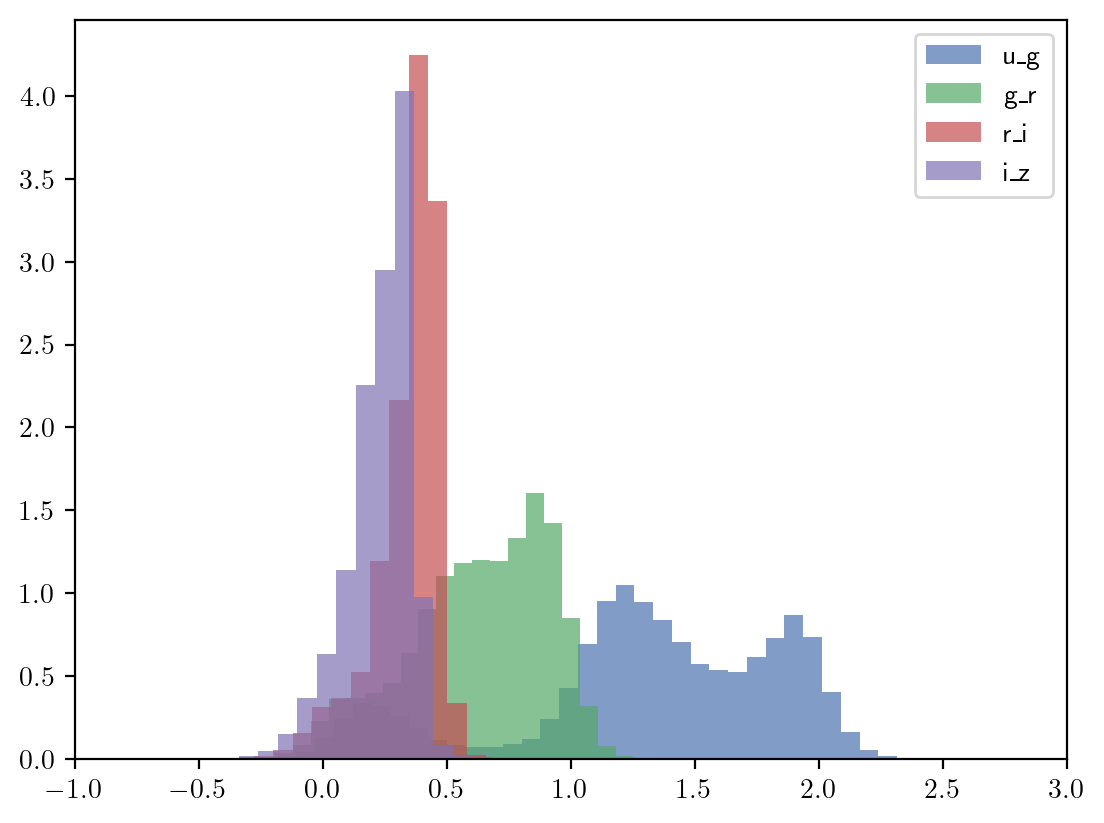

In [7]:
plt.hist(u_g, 100, density=True, label='u_g', alpha=0.7)
plt.hist(g_r, 200, density=True, label='g_r', alpha=0.7)
plt.hist(r_i, 300, density=True, label='r_i', alpha=0.7)
plt.hist(i_z, 300, density=True, label='i_z', alpha=0.7)
plt.xlim(-1, +3)
plt.legend()
plt.show()

#### Label arrays

- galaxy --> 0
- quasar --> 1

In [8]:
class_to_number = {"GALAXY": 0, "QSO": 1}  # mapping
labels = np.array([class_to_number[cl] for cl in data['class']]) # convert the string array to an array of 0/1

y=labels

Split the dataset

In [9]:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

In [10]:
N_tot = len(y)
N_qso = np.sum(y)
N_gal = N_tot - N_qso
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_tot

print('Number of quasars:', N_qso)
print('Number of galaxies:', N_gal)

Number of quasars: 7134
Number of galaxies: 42866


#### Look at the bimodality in color u_g

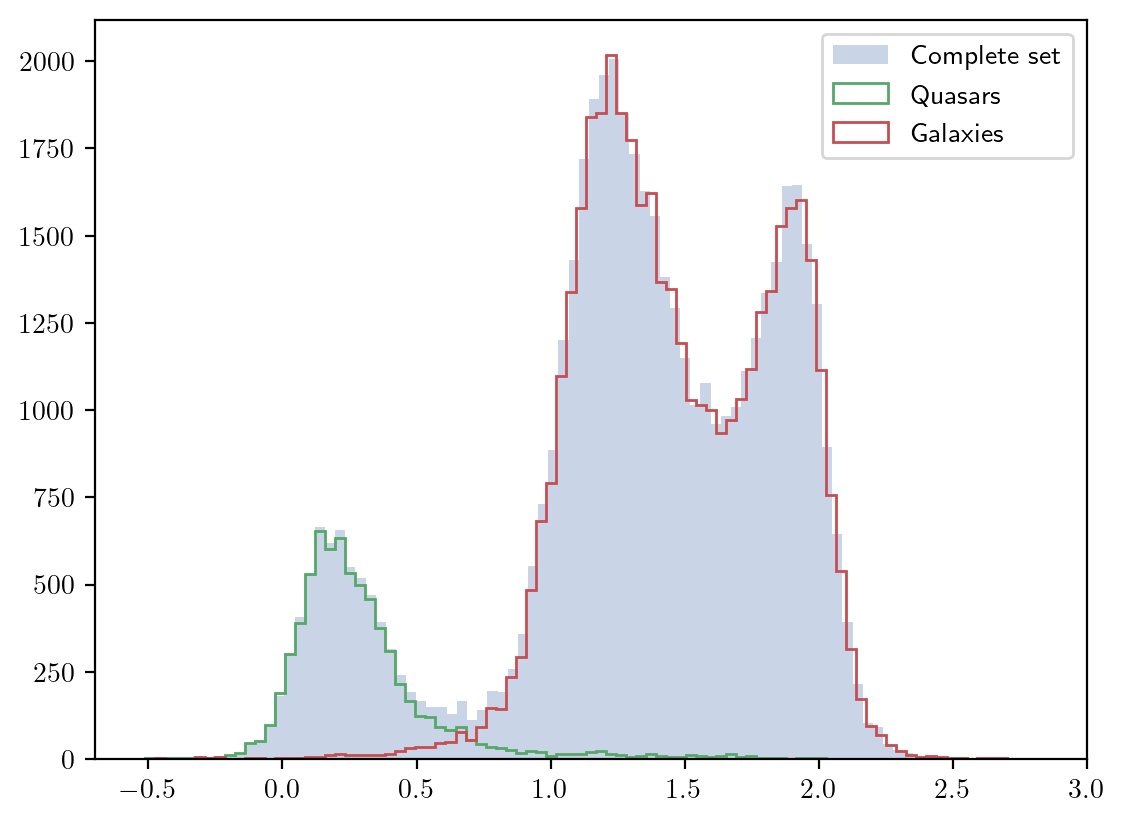

In [11]:
plt.hist(u_g, bins=200, label='Complete set', alpha=0.3)
plt.hist(u_g[labels == 1], histtype='step', bins=np.linspace(-0.7, 3, 100), label='Quasars')
plt.hist(u_g[labels == 0], histtype='step', bins=np.linspace(-0.7, 3, 100), label='Galaxies')

plt.xlim(-0.7, 3)
plt.legend()
plt.show()

Let's see if I'm able to classify those objects with cassifiers.

## Gaussian Naive Bayes

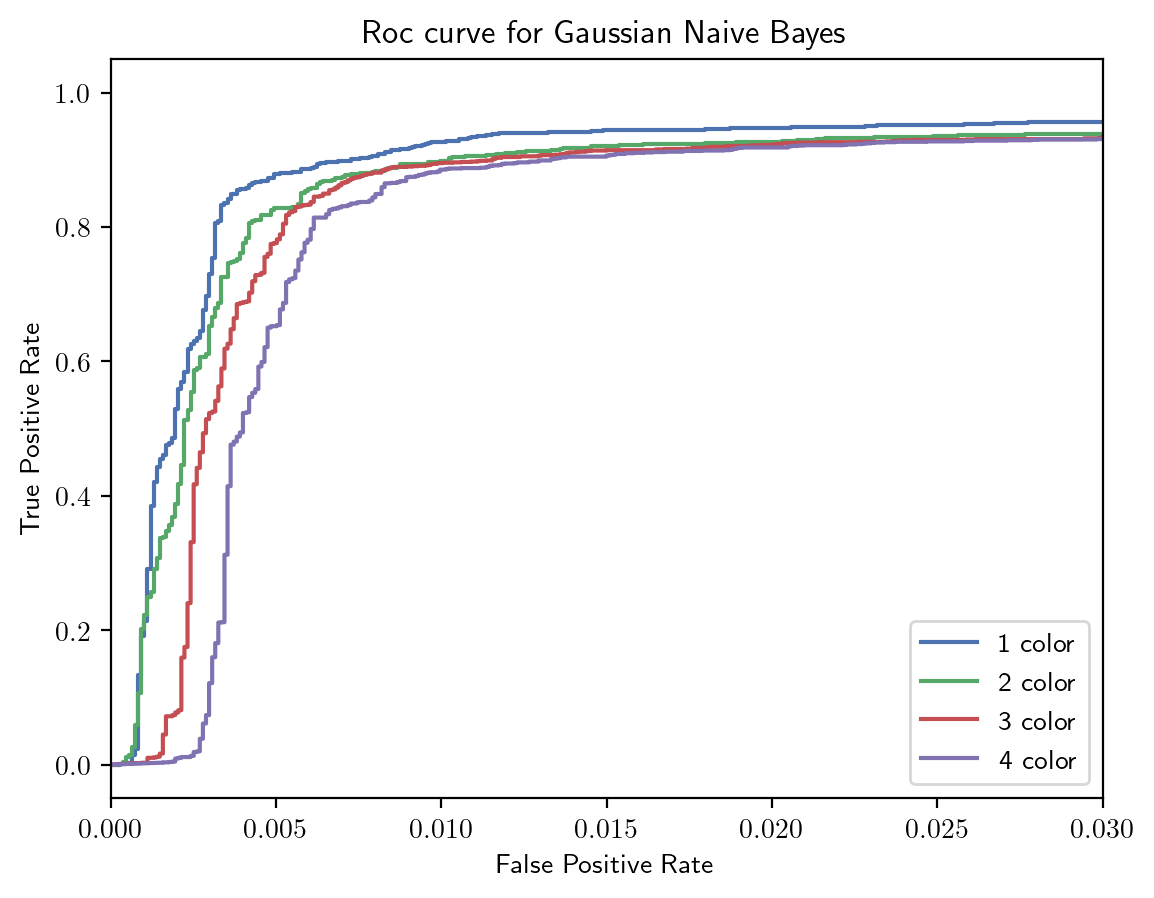

In [12]:
gnb = GaussianNB()

colors = np.arange(X_train[0].size) + 1
completeness = np.zeros(X_train[0].size)
contamination = np.zeros(X_train[0].size)


for ncol in colors:
    X = X_train[:,:ncol]
    y = y_train

    gnb.fit(X,y)

    y_prob = gnb.predict_proba(X_test[:,:ncol])[:,1]
    y_pred = gnb.predict(X_test[:,:ncol])
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)
    
    completeness[ncol-1], contamination [ncol-1] = completeness_contamination(y_pred, y_test)

    plt.plot(fpr, tpr, label=str(ncol)+' color')

plt.xlim(0,0.03)
plt.title('Roc curve for Gaussian Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The first feature seams to be the most relevant one.

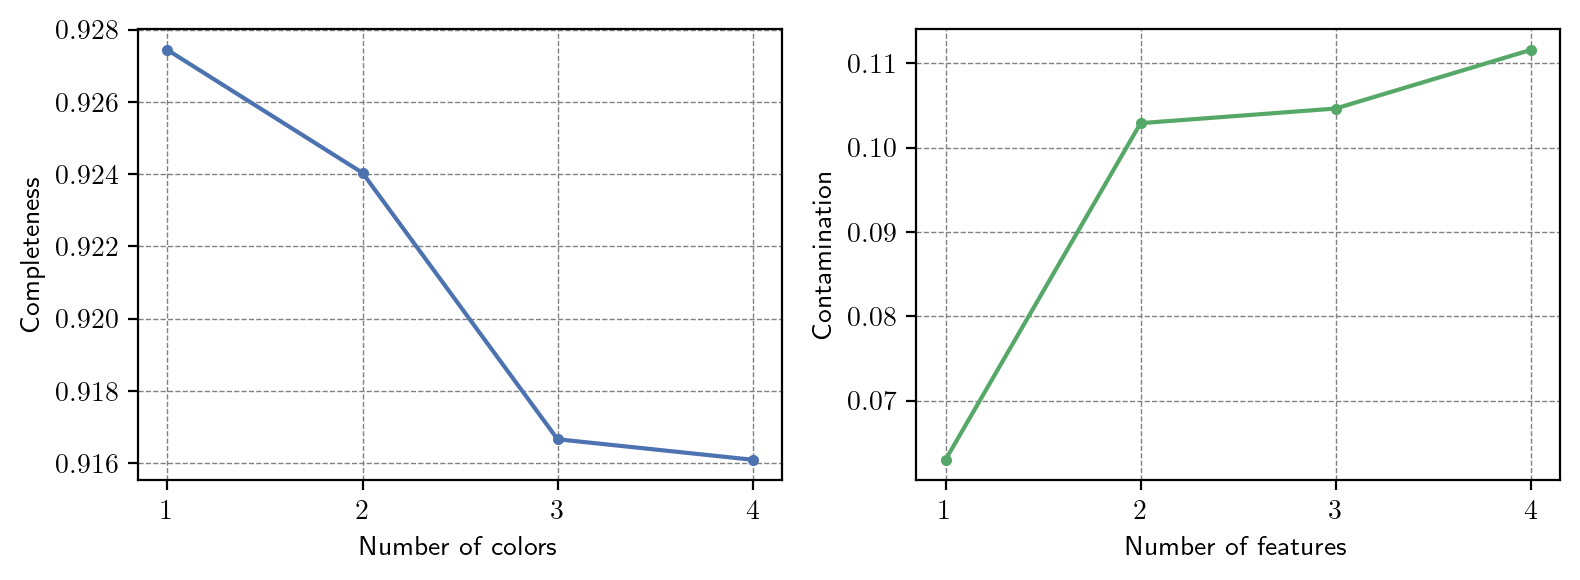

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

axes[0].plot(colors, completeness, marker='.')
axes[0].set_xlabel('Number of colors')
axes[0].set_ylabel('Completeness')
axes[0].set_xticks(colors)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5)

axes[1].plot(colors, contamination, marker='.', color='C1')
axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Contamination')
axes[1].set_xticks(colors)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Quadratic Discriminant Analysis

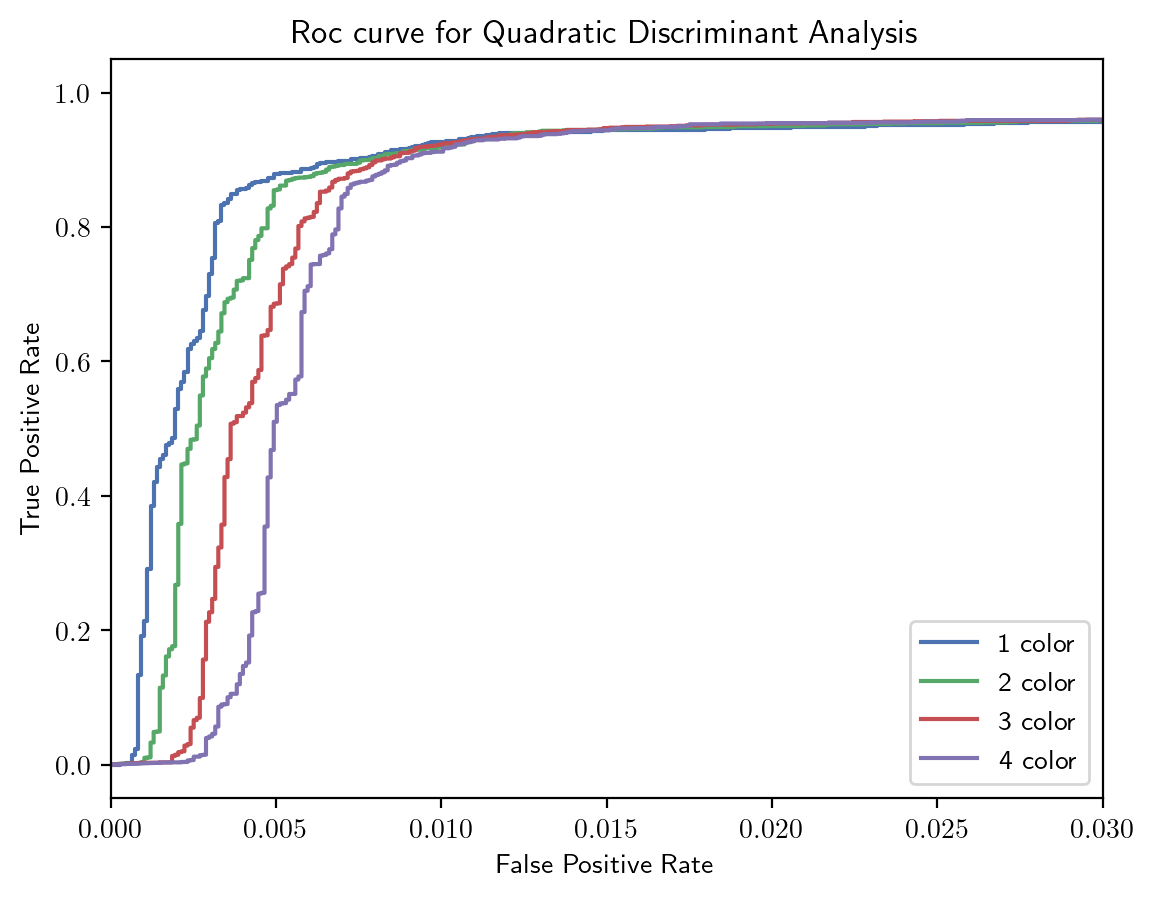

In [14]:
qda = QuadraticDiscriminantAnalysis()

completeness = np.zeros(X_train[0].size)
contamination = np.zeros(X_train[0].size)

for ncol in colors:
    X = X_train[:,:ncol]
    y = y_train

    qda.fit(X,y)

    y_prob = qda.predict_proba(X_test[:,:ncol])[:,1]
    y_pred = qda.predict(X_test[:,:ncol])
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)
    
    completeness[ncol-1], contamination [ncol-1] = completeness_contamination(y_pred, y_test)

    plt.plot(fpr, tpr, label=str(ncol)+' color')

plt.xlim(0,0.03)
plt.title('Roc curve for Quadratic Discriminant Analysis')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

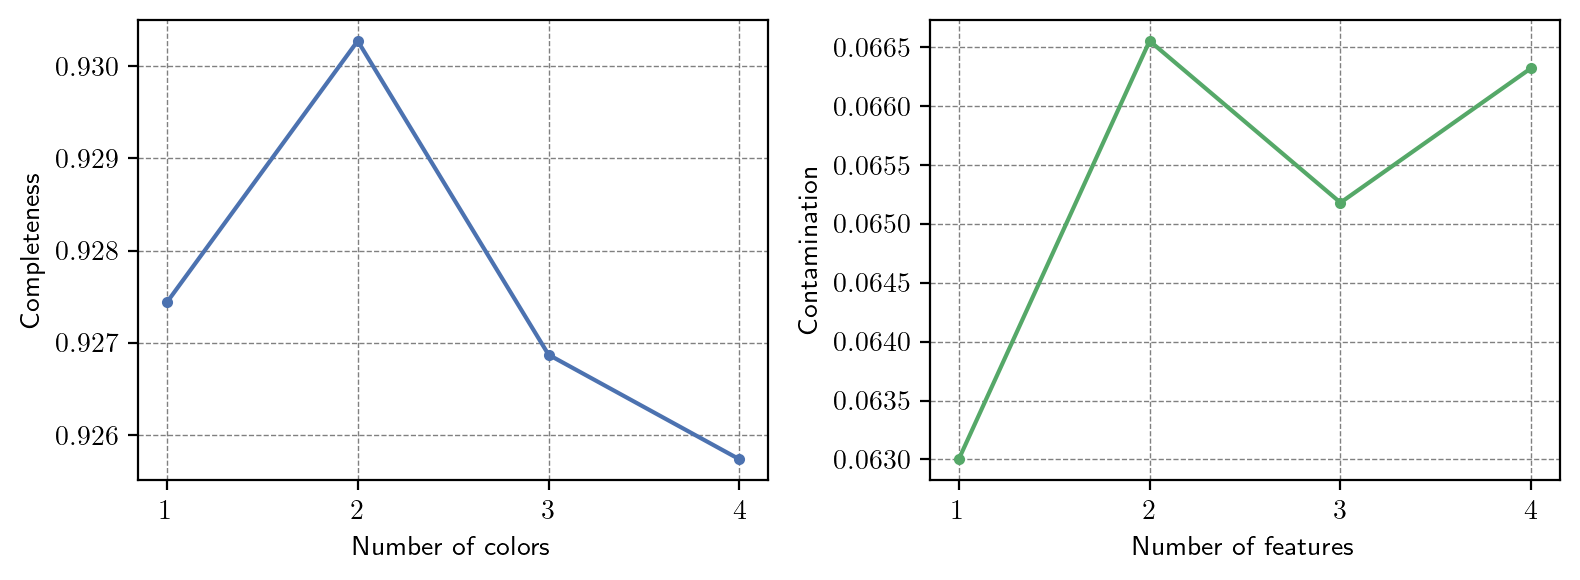

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

axes[0].plot(colors, completeness, marker='.')
axes[0].set_xlabel('Number of colors')
axes[0].set_ylabel('Completeness')
axes[0].set_xticks(colors)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5)

axes[1].plot(colors, contamination, marker='.', color='C1')
axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Contamination')
axes[1].set_xticks(colors)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Gaussian Mixture Bayes Classifier

First: all colors, different number of components for the Gaussian Mixture.

Components GMM:   0%|          | 0/9 [00:00<?, ?it/s]

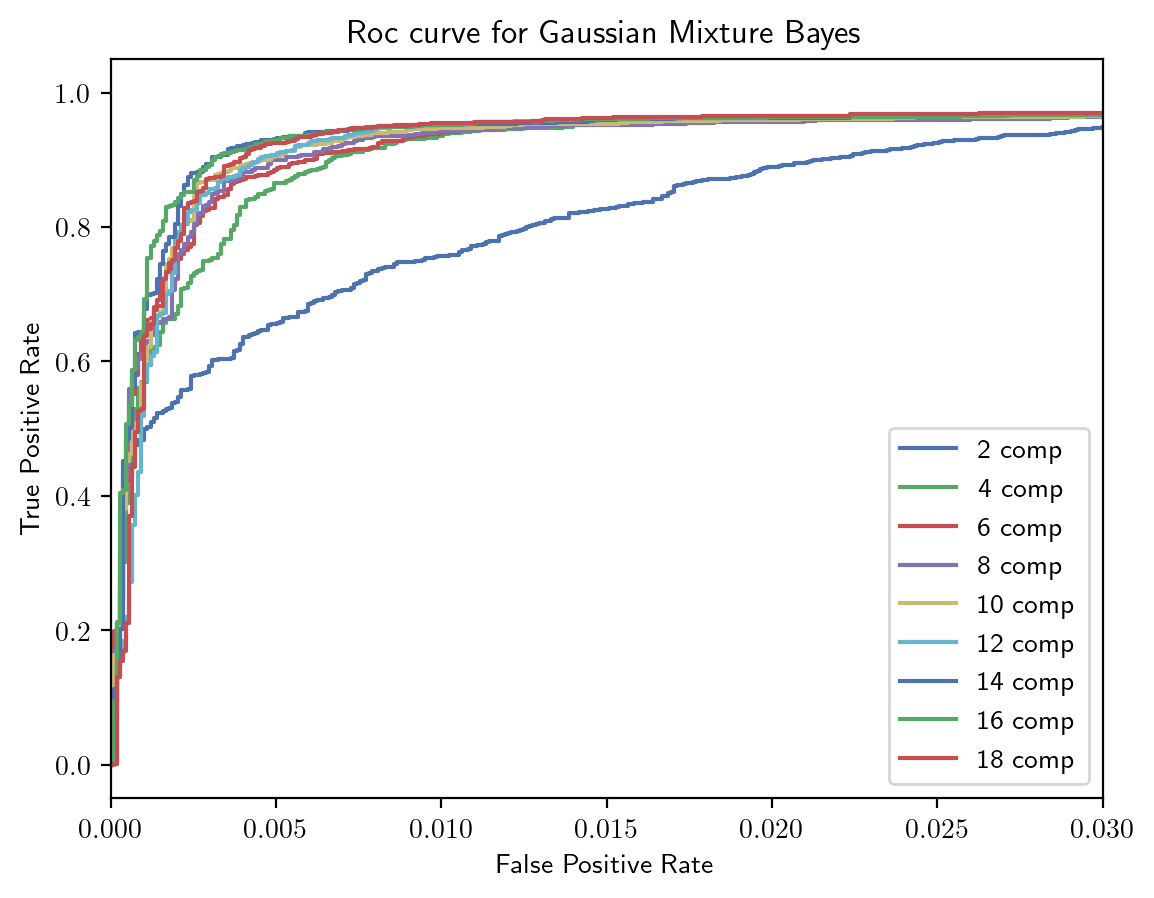

In [16]:
for ncomp in tqdm(range(2, 20, 2), desc="Components GMM"):
    gmm = GMMBayes(n_components=ncomp)
    X = X_train
    y = y_train

    gmm.fit(X,y)

    y_prob = gmm.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)

    plt.plot(fpr, tpr, label=str(ncomp)+' comp')

plt.xlim(0,0.03)
plt.title('Roc curve for Gaussian Mixture Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Now: fix the number of components (e.g. 6 components) and varies the number of colors used in the fit.

Colors:   0%|          | 0/4 [00:00<?, ?it/s]

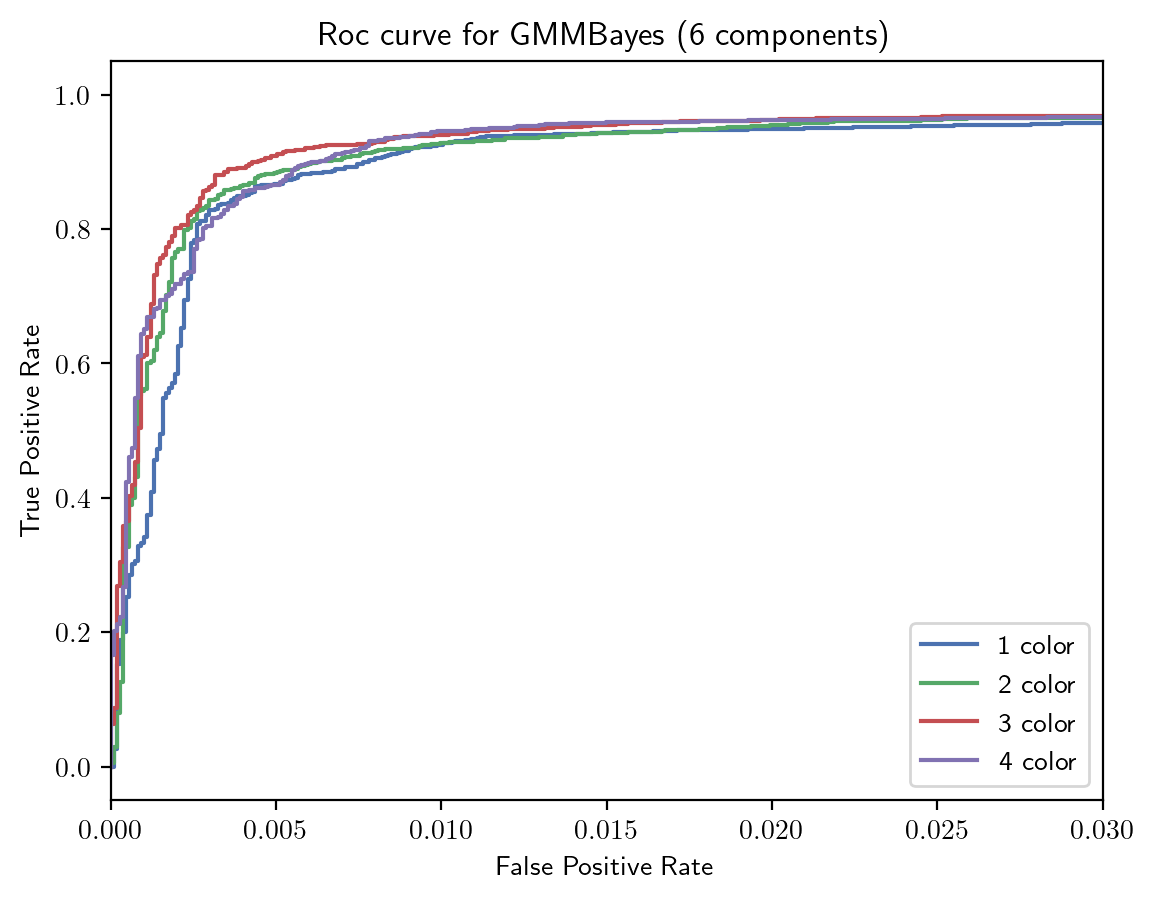

In [17]:
gmm = GMMBayes(n_components=6)

completeness = np.zeros(X_train[0].size)
contamination = np.zeros(X_train[0].size)

for ncol in tqdm(colors, desc="Colors"):
    X = X_train[:,:ncol]
    y = y_train

    gmm.fit(X,y)

    y_prob = gmm.predict_proba(X_test[:,:ncol])[:,1]
    y_pred = gmm.predict(X_test[:,:ncol])
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)

    completeness[ncol-1], contamination [ncol-1] = completeness_contamination(y_pred, y_test)

    plt.plot(fpr, tpr, label=str(ncol)+' color')

plt.xlim(0,0.03)
plt.title('Roc curve for GMMBayes (6 components)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The first feature doesn’t appear to be the most significant one here.

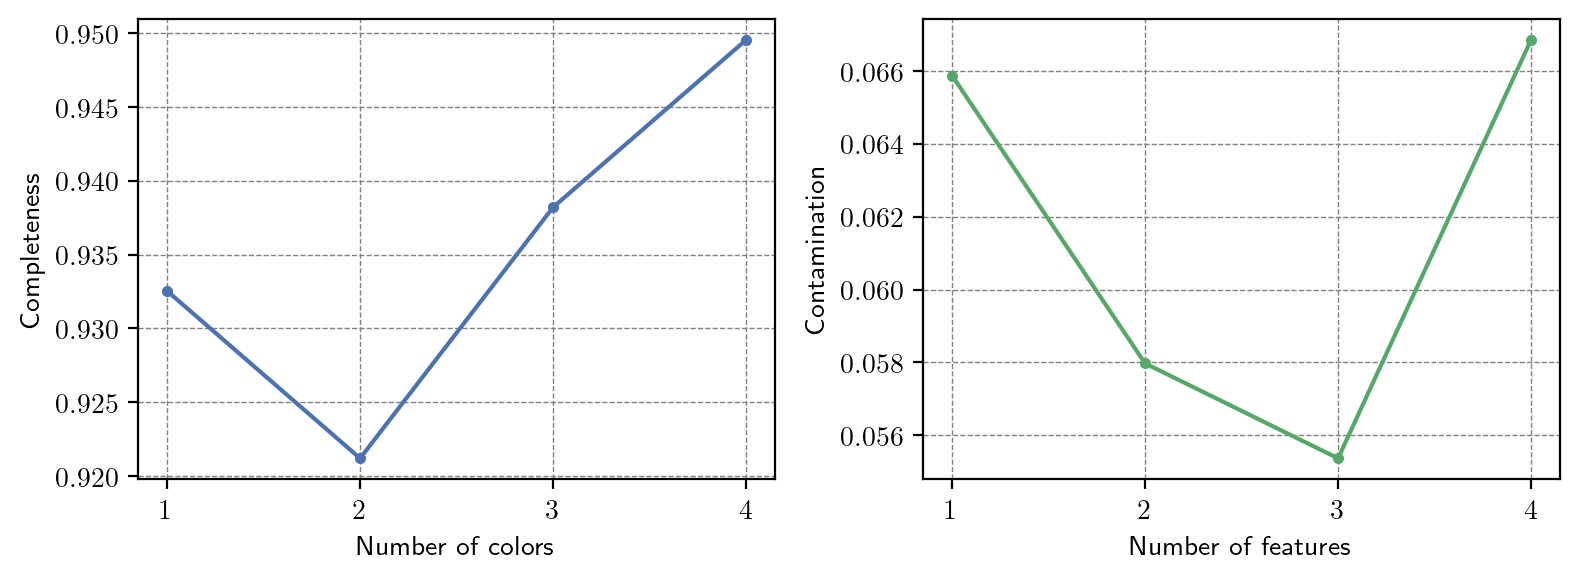

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

axes[0].plot(colors, completeness, marker='.')
axes[0].set_xlabel('Number of colors')
axes[0].set_ylabel('Completeness')
axes[0].set_xticks(colors)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5)

axes[1].plot(colors, contamination, marker='.', color='C1')
axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Contamination')
axes[1].set_xticks(colors)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## K-Neighbors Classifier

Neighbors:   0%|          | 0/10 [00:00<?, ?it/s]

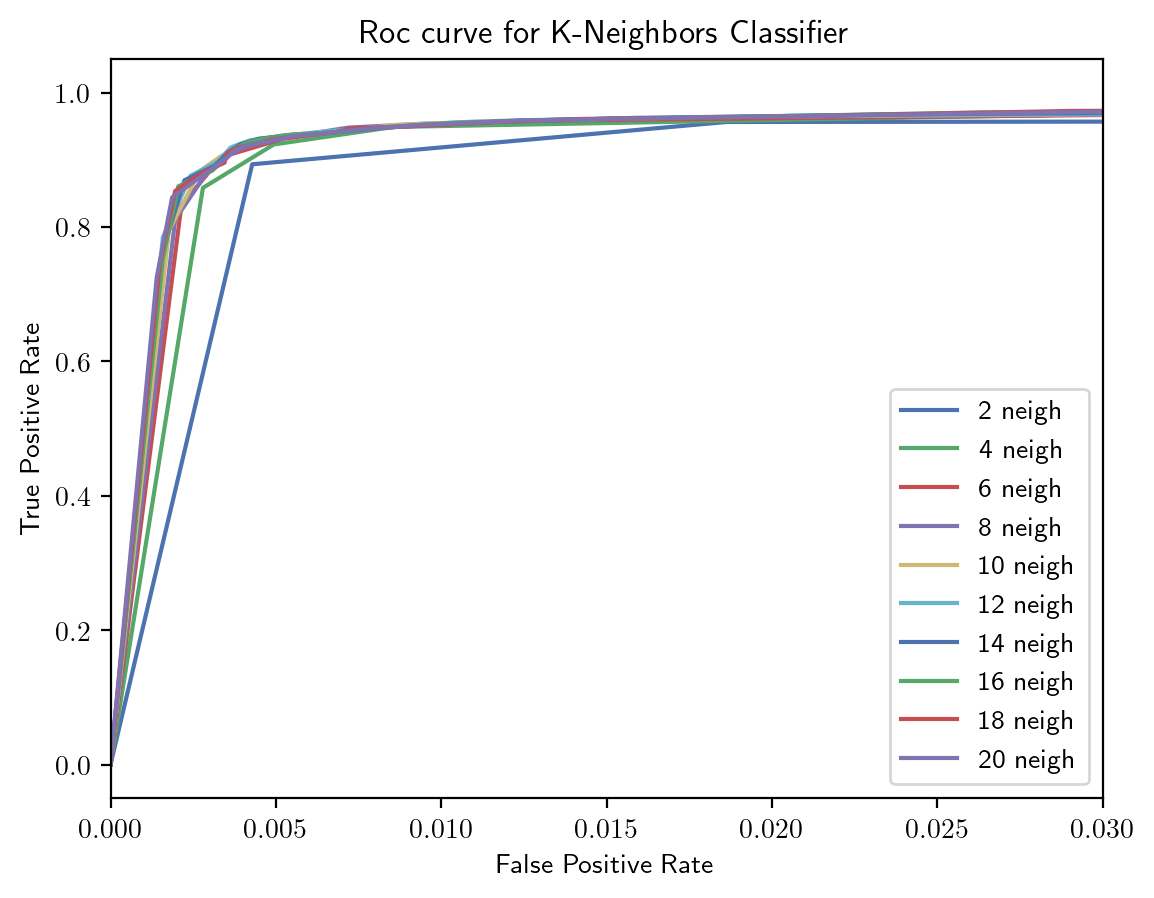

In [19]:
for ncomp in tqdm(range(2, 21, 2), desc="Neighbors"):
    neigh = KNeighborsClassifier(n_neighbors=ncomp)
    X = X_train
    y = y_train

    neigh.fit(X,y)

    y_prob = neigh.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)

    plt.plot(fpr, tpr, label=str(ncomp)+' neigh')

plt.xlim(0,0.03)
plt.title('Roc curve for K-Neighbors Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Colors:   0%|          | 0/4 [00:00<?, ?it/s]

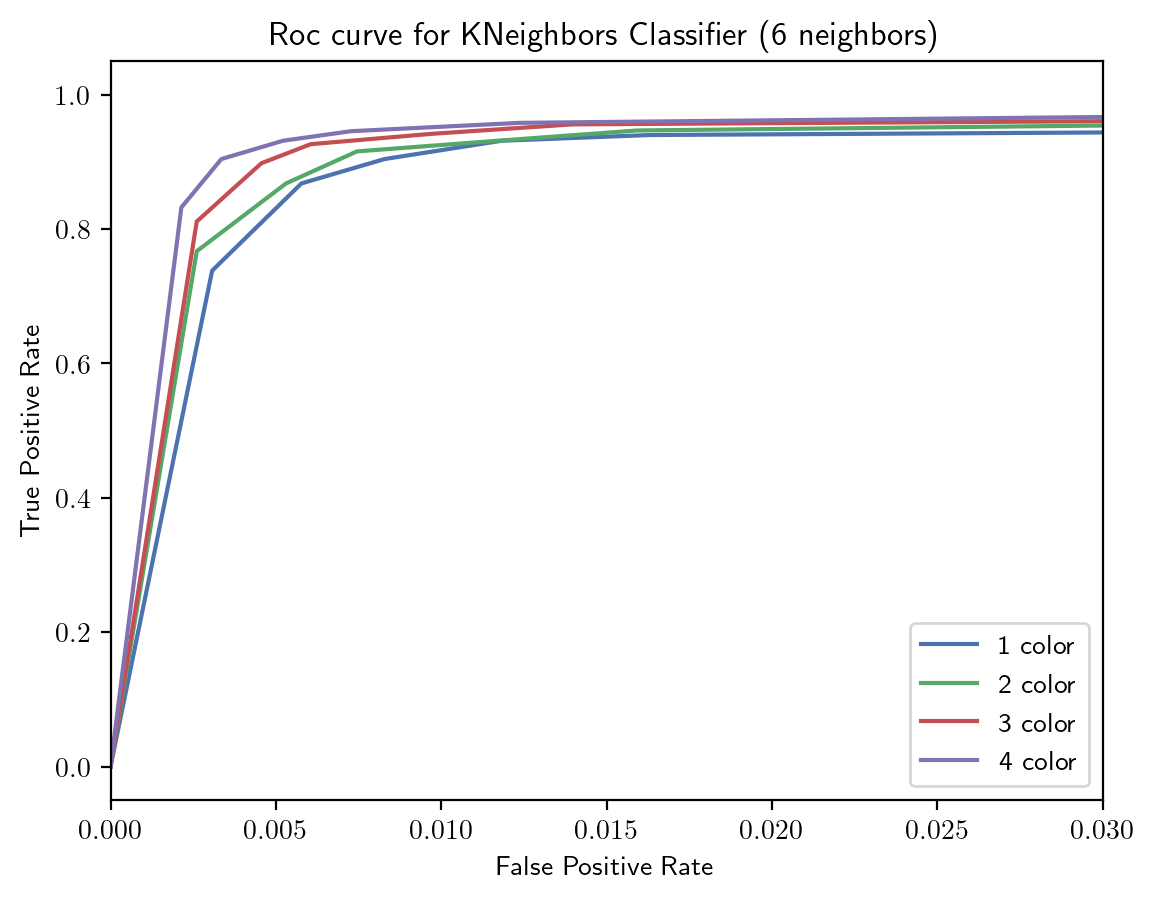

In [20]:
neigh = KNeighborsClassifier(n_neighbors=6)

completeness = np.zeros(X_train[0].size)
contamination = np.zeros(X_train[0].size)

for ncol in tqdm(colors, desc="Colors"):
    X = X_train[:,:ncol]
    y = y_train

    neigh.fit(X,y)

    y_prob = neigh.predict_proba(X_test[:,:ncol])[:,1]
    y_pred = neigh.predict(X_test[:,:ncol])
    fpr, tpr, thresholds = roc_curve(y_test,y_prob)

    completeness[ncol-1], contamination [ncol-1] = completeness_contamination(y_pred, y_test)

    plt.plot(fpr, tpr, label=str(ncol)+' color')

plt.xlim(0,0.03)
plt.title('Roc curve for KNeighbors Classifier (6 neighbors)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

All color components seem to help improve the fit, with the quality gradually getting better as more are added.

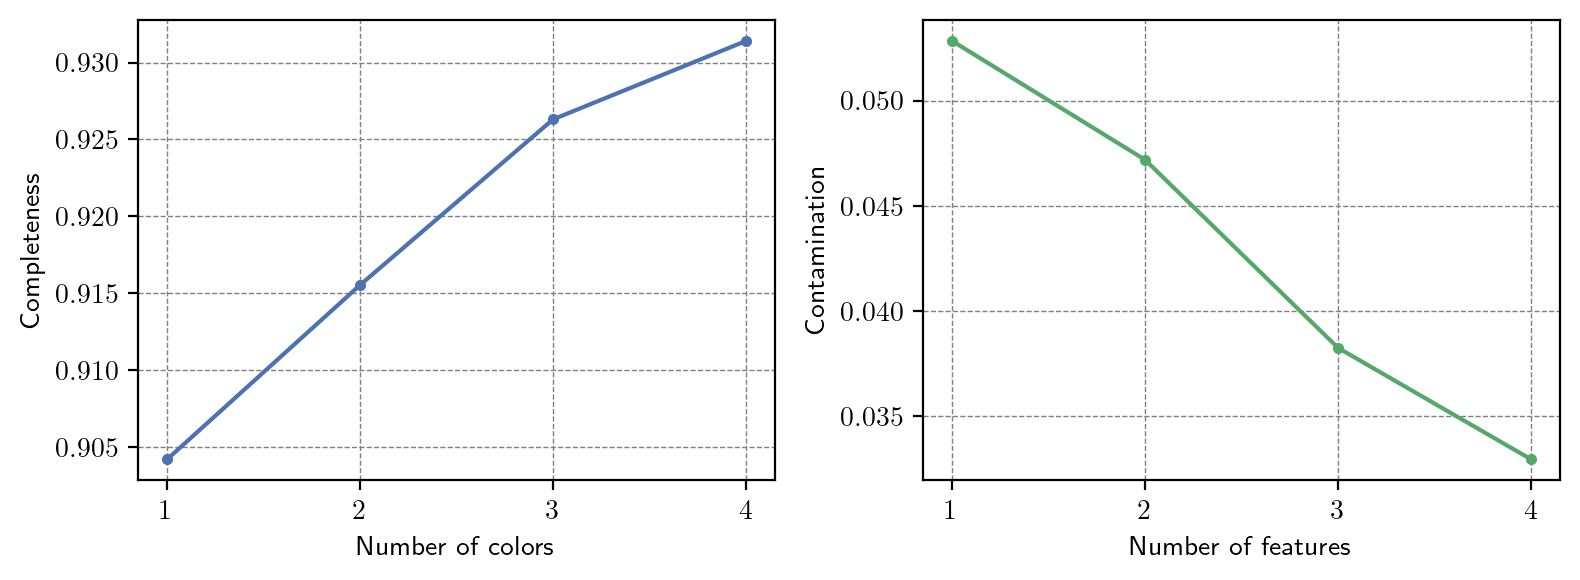

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

axes[0].plot(colors, completeness, marker='.')
axes[0].set_xlabel('Number of colors')
axes[0].set_ylabel('Completeness')
axes[0].set_xticks(colors)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5)

axes[1].plot(colors, contamination, marker='.', color='C1')
axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Contamination')
axes[1].set_xticks(colors)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Correlation matrix of the colors

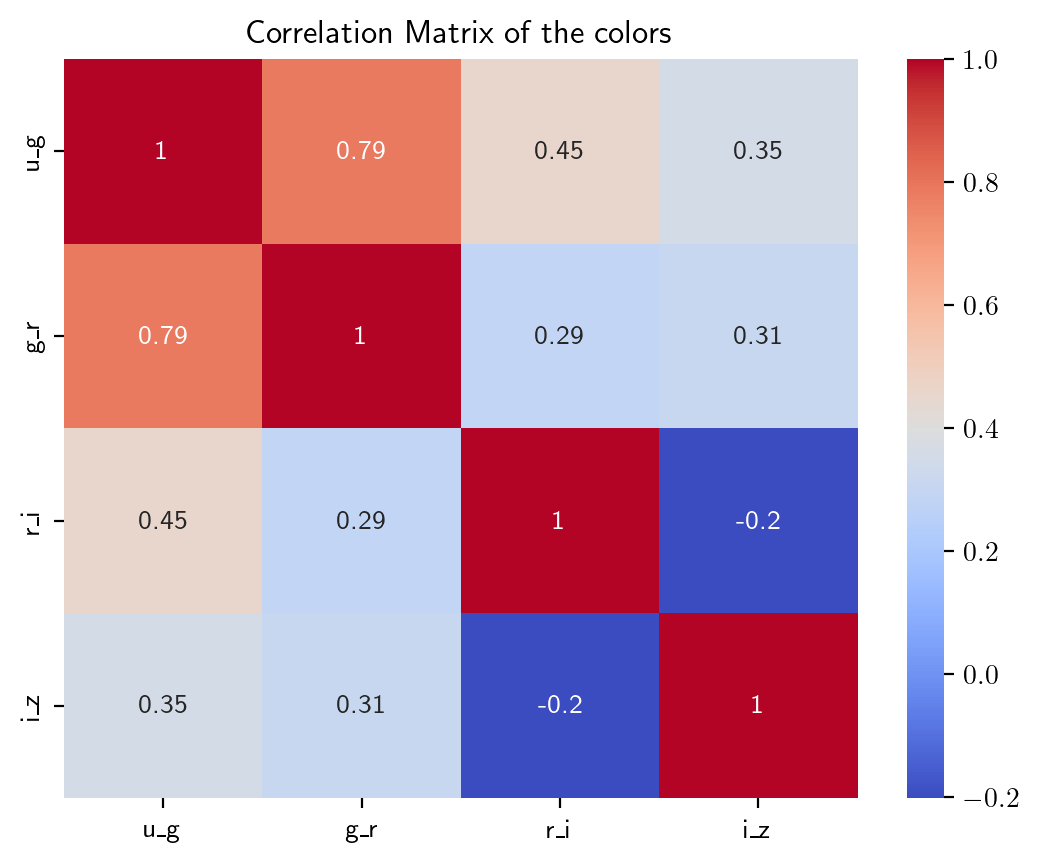

In [22]:
df = pd.DataFrame(X, columns=['u_g', 'g_r', 'r_i', 'i_z'])
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of the colors")
plt.show()

The colors appear to be correlated, with a particularly strong relationship between u_g and g_r.

## Classification for color u_g using GMMBayes

In [23]:
gmm = GMMBayes(n_components=6)

X = X_train
y = y_train

gmm.fit(X,y)

y_pred = gmm.predict(X_test)

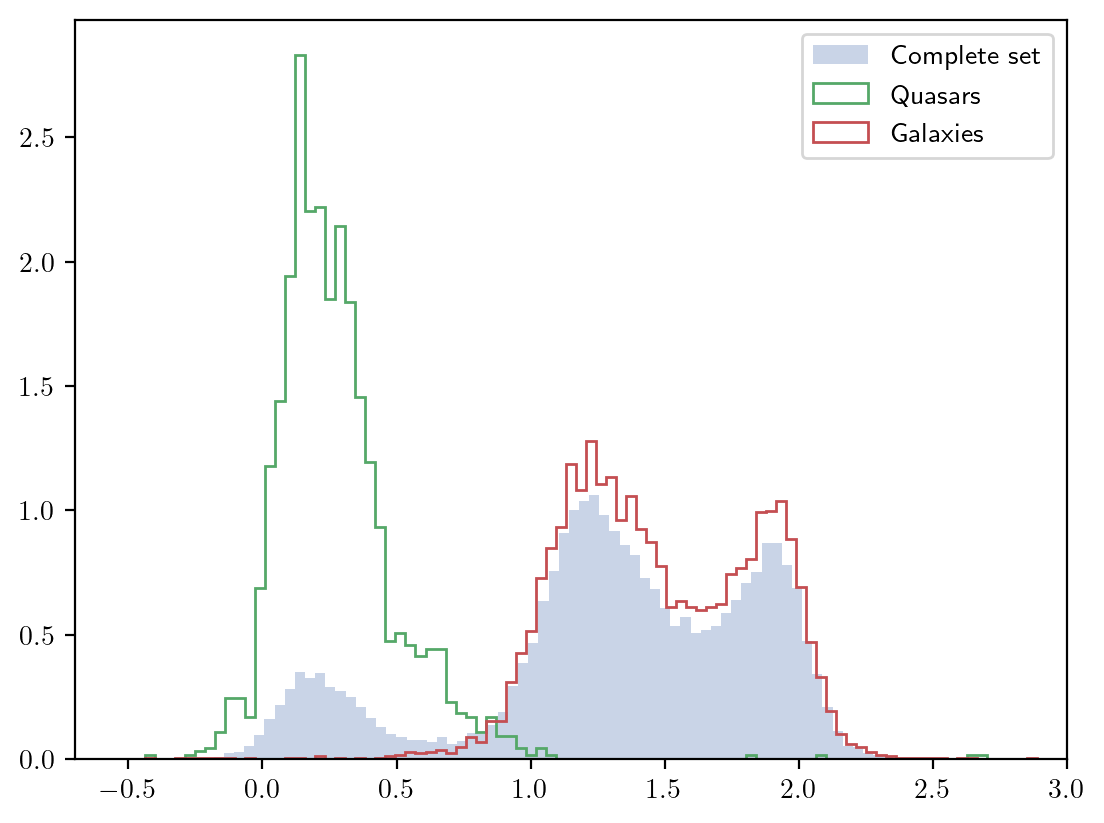

In [24]:
plt.hist(u_g, bins=200, label='Complete set', alpha=0.3, density=True)
plt.hist(X_test[:,0][y_pred == 1], histtype='step', bins=np.linspace(-0.7, 3, 100), label='Quasars', density=True)
plt.hist(X_test[:,0][y_pred == 0], histtype='step', bins=np.linspace(-0.7, 3, 100), label='Galaxies', density=True)

plt.xlim(-0.7, 3)
plt.legend()
plt.show()

The bimodality is reconstructed.